<a href="https://colab.research.google.com/github/tony-wade/optimizers/blob/main/SPSA/SPSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Author Information
This code is provided by **Wade Wu**.

For license information, please visit my [GitHub repository](https://github.com/tony-wade/optimizers). Contributions and feedback are always welcome!


## Code



```
Note: This optimizer requires a closure function.

    # Loop
    def closure():
          outputs = model(features)
          return criterion(outputs, targets)
    optimizer.step(closure)
```



In [ ]:
class SPSA(torch.optim.Optimizer):
    """
    Stochastic Perturbation Stochastic Approximation (SPSA) optimizer with Nesterov Accelerated Gradient (NAG).

    Args:
        params (torch.nn.Module.parameters)
        a (float): Initial learning‐rate coefficient (default: 0.63).
        c (float): Initial perturbation magnitude coefficient (default: 0.1).
        A (float): Stability constant for learning‐rate schedule (default: 1).
        alpha (float): Exponent for learning‐rate decay (default: 0.603).
        gamma (float): Exponent for perturbation decay (default: 0.101).
        momentum (float): Momentum factor for Nesterov acceleration (default: 0.9).
        nesterov (bool): If True, apply Nesterov Accelerated Gradient (default: True).
    """
    def __init__(self, params, a=0.63, c=0.1, A=1, alpha=0.603, gamma=0.101, momentum=0.9, nesterov=True):
        defaults = dict(a=a, c=c, A=A, alpha=alpha, gamma=gamma, momentum=momentum)
        super().__init__(params, defaults)   # enable .param_groups
        self.t = 0    #  iter_num
        self.nesterov = nesterov
        self.deltas = [
                 torch.zeros_like(nn.utils.parameters_to_vector(group['params']))
                 for group in self.param_groups
        ]
        if nesterov:
            self.prev_grad_vec = [
                torch.zeros_like(nn.utils.parameters_to_vector(group['params']))
                for group in self.param_groups
            ]
            self.prev_nes_vec = [
                torch.zeros_like(nn.utils.parameters_to_vector(group['params']))
                for group in self.param_groups
            ]

    @torch.no_grad()
    def _cal_nesterov(self, idx, grad, momentum):
        prev_grad = self.prev_grad_vec[idx]   # get relative param_group's data
        prev_nes_grad = self.prev_nes_vec[idx]

        nes_grad_vec = grad + (prev_nes_grad + grad - prev_grad) * momentum

        self.prev_nes_vec[idx] = nes_grad_vec
        self.prev_grad_vec[idx] = grad

        return nes_grad_vec

    @torch.no_grad()
    def step(self, closure):
        self.t += 1
        for idx, group in enumerate(self.param_groups):
            # Adaptive variebles
            a_t = group['a'] / (self.t + group['A']) ** group['alpha']
            c_t = (group['c'] / self.t ** group['gamma']) + 1e-4   # 避免極小值

            param_vec = nn.utils.parameters_to_vector(group['params'])
            deltas = self.deltas[idx].random_(0, 2).mul_(2).add_(-1)  # {+1,-1}

            # SPSA
            nn.utils.vector_to_parameters(param_vec + deltas * c_t, group['params'])
            loss_plus = closure()

            nn.utils.vector_to_parameters(param_vec - deltas * c_t, group['params'])
            loss_minus = closure()

            estimated_grad_vec = (loss_plus - loss_minus) / (2 * deltas * c_t)

            if self.nesterov:
                nesterov_grad = self._cal_nesterov(idx, estimated_grad_vec, group['momentum'])
                nn.utils.vector_to_parameters(param_vec - a_t * nesterov_grad, group['params'])
            else:
                nn.utils.vector_to_parameters(param_vec - a_t * estimated_grad_vec, group['params'])

## Test

Epoch 100, Loss: 0.6594
Epoch 200, Loss: 0.5409
Epoch 300, Loss: 0.4674
Epoch 400, Loss: 0.4111
Epoch 500, Loss: 0.3727
Epoch 600, Loss: 0.3409
Epoch 700, Loss: 0.3109
Epoch 800, Loss: 0.2973
Epoch 900, Loss: 0.2753
Epoch 1000, Loss: 0.2620


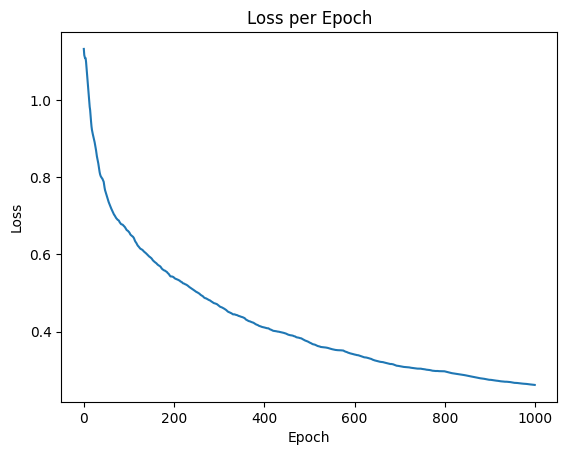

In [ ]:
if __name__ == '__main__':
    input_size, hidden_size, output_size = 10, 10, 10
    batch_size = 20
    model = SimpleNN(input_size, hidden_size, output_size)
    initialize_parameters(model)
    data_loader = initialize_training_data(input_size, output_size, batch_size)

    criterion = nn.SmoothL1Loss()
    optimizer = SPSA(model.parameters(), a=0.1)

    loss_list = []
    # Training Loop
    for epoch in range(1000):
        loss = 0
        for batch_x, batch_y in data_loader:
            def closure():
                batch_output = model(batch_x)
                return criterion(batch_output, batch_y)

            optimizer.step(closure)
            loss += closure()

        loss_list.append(loss.item()/len(data_loader))  # avg batch loss

        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()/len(data_loader) :.4f}")

    plt.plot(loss_list)
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()